# Setup

In [20]:
# import useful library, module, class, function, etc.
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import RFE, RFECV

# Business Understanding

- A house price could be predicted from the historical data of another houses
- Price is continuous, therefore I will need algorithms that could solve a regression task
- The algorithm that I will try to use is linear regression

# Data Understanding

In [21]:
# load dataset (csv) into pandas dataframe
df = pd.read_csv("/content/kc_house_data.csv")

In [22]:
# show the high-level information of dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

> The only variable with a non-numeric data type based on the info above is `date`, it is stored as an object. I assume this variable is referring to the time a data is collected. I'm going to overlook this variable since I don't think it can be use to predict `price`.

In [23]:
# show the sample of data in the dataframe
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


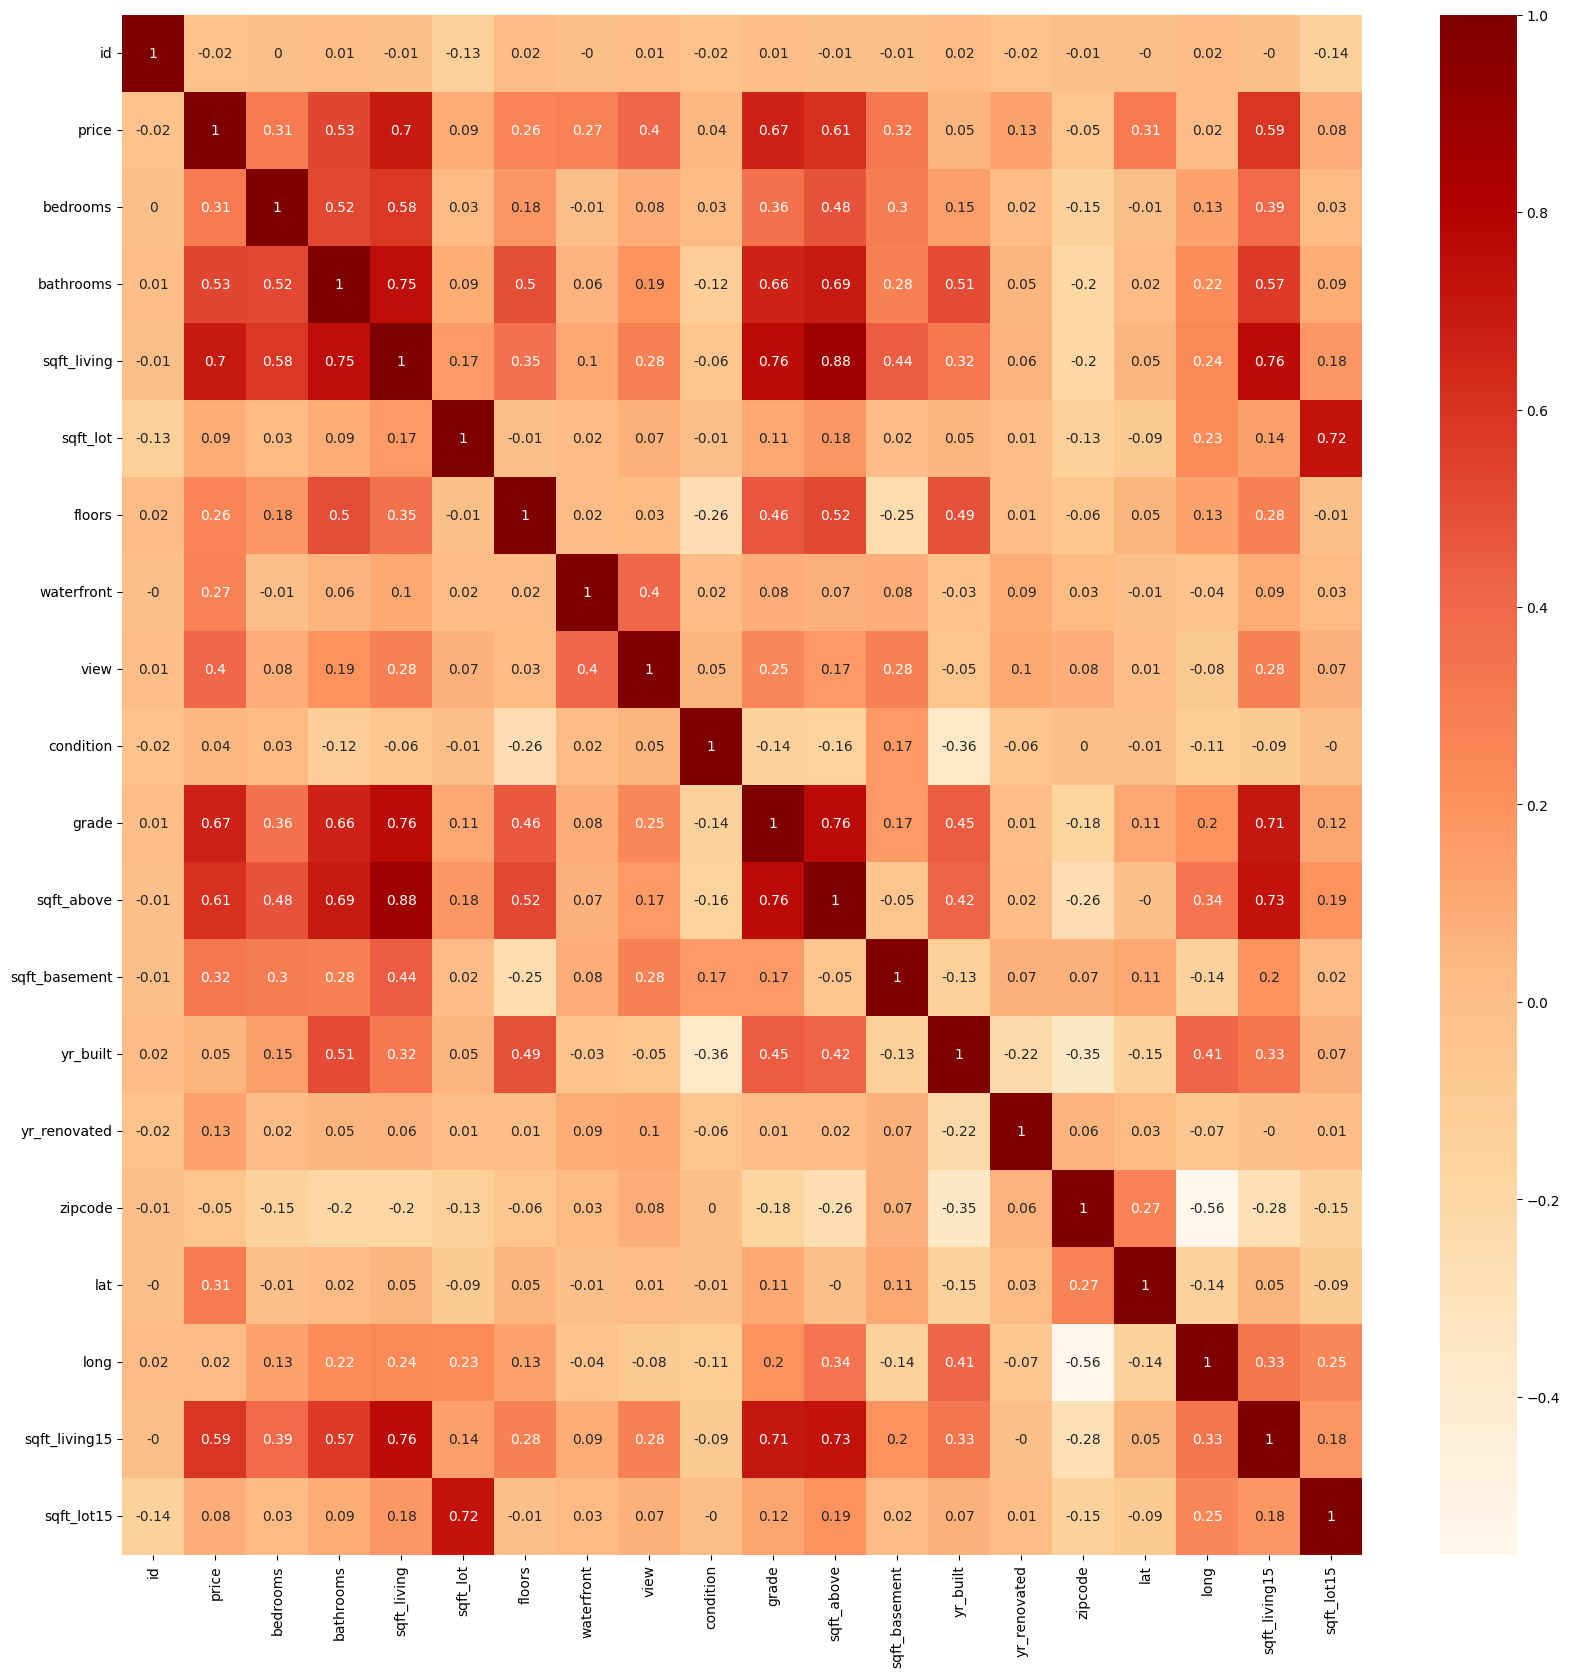

In [24]:
# correlation matrix for all numerical variables
plt.figure(figsize=(20,20))
compute_correlation_matrix = df.corr(numeric_only=True).round(2)
sns.heatmap(compute_correlation_matrix, annot=True, cmap='OrRd')
plt.show()

# Data Preparation

## Cleaning

Based on the high-level information of this dataset, all "non-null count" values are equal to the number of entries. It means that this dataset does not contain any missing value. Therefore, I will move forward to checking the presents of outlier and duplicate data.

In [25]:
def outlier_percentage(dataframe):
  Q1 = dataframe.quantile(0.25)
  Q3 = dataframe.quantile(0.75)
  IQR = Q3 - Q1
  RLB = Q1 - 1.5 * IQR
  RUB = Q3 + 1.5 * IQR
  return round(((dataframe < RLB) | (dataframe > RUB)).sum()/dataframe.count()*100, 2)

In [26]:
# counting the percentage of outlier in each column
outlier_percentage(df.select_dtypes(include='number'))

id                0.00
price             5.30
bedrooms          2.53
bathrooms         2.64
sqft_living       2.65
sqft_lot         11.22
floors            0.00
waterfront        0.75
view              9.83
condition         0.14
grade             8.84
sqft_above        2.83
sqft_basement     2.29
yr_built          0.00
yr_renovated      4.23
zipcode           0.00
lat               0.01
long              1.18
sqft_living15     2.52
sqft_lot15       10.15
dtype: float64

> I assume that if the outlier that present on a column is >=1%, it is indeed a real value recorded and is not an error from observation. Therefore, I don't have to remove those outliers.

> `waterfront`, `condition` & `lat` has <1% outlier. But I won't handle `waterfront` because based on the data understanding stage it contains boolean datatypes, so none of the data should actually be considered as outlier.

In [27]:
def remove_outlier(dataframe, col_name):
  Q1 = dataframe[col_name].quantile(0.25)
  Q3 = dataframe[col_name].quantile(0.75)
  IQR = Q3 - Q1
  RLB = Q1 - 1.5 * IQR
  RUB = Q3 + 1.5 * IQR
  new_dataframe = dataframe.loc[~((dataframe[col_name] < RLB) | (dataframe[col_name] > RUB))]
  return new_dataframe

In [28]:
# creating new dataframe by selecting row WITHOUT outlier
df_clean = remove_outlier(df, "condition")
df_clean = remove_outlier(df_clean, "lat")

In [29]:
print("Number of row(s) after handling some outliers:", len(df_clean))

Number of row(s) after handling some outliers: 21581


In [30]:
# check whether there are duplicated row in the dataframe
df_clean.duplicated().sum()

0

> Up until here the dataset has been cleansed. The size of row has been reduced from 21.613 to 21.581

## Standardization

Numerical variables that was measured with different scales can cause bias when further processed in modelling stage. Therefore, it is better to standardize (scaled) those number. The technique that I will use is RobustScaler from SKLearn because this dataset contains some outlier. Further reading: https://scikit-learn.org/stable/modules/preprocessing.html#scaling-data-with-outliers

I won't scaled the target variables as it is not necessary. Scaling the target variable just make it harder to interpret the prediction.

In [31]:
numerical_data = df_clean.select_dtypes(include='number').drop("price", axis=1)
numerical_data.head()

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


In [32]:
df_robust_scaled = pd.DataFrame()
df_robust_scaled[numerical_data.columns] = RobustScaler().fit_transform(numerical_data)
display(df_robust_scaled)

,id,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0.621801,0.0,-1.666667,-0.651786,-0.348713,-0.5,0.0,0.0,0.0,0.0,-0.372549,0.000000,-0.444444,0.0,1.329412,-0.292471,-0.133005,-0.574713,-0.395582
1,0.483879,0.0,0.000000,0.589286,-0.066193,0.5,0.0,0.0,0.0,0.0,0.598039,0.714286,-0.533333,1991.0,0.705882,0.720077,-0.438424,-0.172414,0.003815
2,0.332960,-1.0,-1.666667,-1.017857,0.423248,-0.5,0.0,0.0,0.0,-1.0,-0.774510,0.000000,-0.933333,0.0,-0.435294,0.801641,-0.014778,1.011494,0.088755
3,-0.273398,1.0,1.000000,0.044643,-0.464064,-0.5,0.0,0.0,2.0,0.0,-0.500000,1.625000,-0.222222,0.0,0.835294,-0.246139,-0.802956,-0.551724,-0.526104
4,-0.376145,0.0,-0.333333,-0.205357,0.082520,-0.5,0.0,0.0,0.0,1.0,0.117647,0.000000,0.266667,0.0,0.105882,0.217181,0.911330,-0.045977,-0.023494
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21576,-0.702321,0.0,0.333333,-0.339286,-1.150665,1.5,0.0,0.0,0.0,1.0,-0.029412,0.000000,0.755556,0.0,0.447059,0.615347,-0.571429,-0.356322,-1.227108
21577,0.519740,1.0,0.333333,0.357143,-0.319787,0.5,0.0,0.0,0.0,1.0,0.735294,0.000000,0.866667,0.0,0.952941,-0.294884,-0.650246,-0.011494,-0.084337
21578,-0.459280,-1.0,-2.000000,-0.794643,-1.111801,0.5,0.0,0.0,0.0,0.0,-0.529412,0.000000,0.755556,0.0,0.929412,0.109073,-0.339901,-0.942529,-1.127108
21579,-0.696862,0.0,0.333333,-0.276786,-0.927595,0.5,0.0,0.0,0.0,1.0,0.039216,0.000000,0.644444,0.0,-0.447059,-0.180019,0.793103,-0.494253,-1.271687


# Modeling

## Simple linear regression

### Feature selection
Select the feature variables (X) that will be used to predict the target variables (y)

In [33]:
feature = df_robust_scaled[['sqft_living']]

> The feature is selected based on correlation matrix

### Model development

In [34]:
# selecting target (y) variable
target = df_clean['price']

In [35]:
# randomly split the feature & target data into train set & test set
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=.2, random_state=42)

In [36]:
# construct the model
model_slr = LinearRegression()

In [37]:
# train & validate the model using cross-validation method
scores = cross_validate(model_slr, X_train, y_train,
                        scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'],
                        cv=10,
                        verbose=2)

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


In [38]:
scores

{'fit_time': array([0.03196359, 0.00522923, 0.00619507, 0.00323415, 0.00311184,
        0.00315452, 0.00373459, 0.00325632, 0.00350571, 0.0032413 ]),
 'score_time': array([0.00392079, 0.00327253, 0.00259042, 0.00212765, 0.00210547,
        0.00220609, 0.0021584 , 0.00249171, 0.0022378 , 0.00222826]),
 'test_r2': array([0.48408451, 0.48873726, 0.50144286, 0.47443272, 0.50809737,
        0.49565194, 0.4827669 , 0.52813593, 0.45752596, 0.48759306]),
 'test_neg_root_mean_squared_error': array([-285605.04721962, -246288.01935235, -275771.35106366,
        -248660.99001119, -247885.81476774, -268233.03894736,
        -262943.6716168 , -248542.85660033, -248460.7290584 ,
        -267238.2500225 ]),
 'test_neg_mean_absolute_error': array([-178013.15367679, -169425.7826767 , -175287.7446321 ,
        -169722.75879946, -168647.04605628, -170931.06377753,
        -177954.04714651, -164943.50151331, -175451.29286174,
        -173058.00099653])}

### Evaluation

The model will be evaluated by the metrics from cross-validation method. I will calculate the mean of every metrics. Cross-validation is important to make sure that the model behave similarly when validated on different test set.

In [39]:
# modelling metrics: coefficient of determination (r-squared)
round(np.mean(scores['test_r2']), 2)

0.49

In [40]:
# modelling metrics: root mean squared error (RSME)
round(np.mean(scores['test_neg_root_mean_squared_error']*-1))

259963

In [41]:
# modelling metrics: mean absolute error (MAE)
round(np.mean(scores['test_neg_mean_absolute_error']*-1))

172343

> Both RMSE and R- Squared quantifies how well a linear regression model fits a dataset. The **RMSE** tells how well the regression **model** **can predict** the value of the target variable in absolute terms. Meanwhile, **R- Squared** tells how well the **feature variables can explain** the variation in the target variable.
Further reading: https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e

> On top of that, there is also **MAE**. MAE is interpreted as the average error when making a prediction with the model. RMSE on the other hand can be interpreted as the average weighted performance of the model, where a larger weight is added to outlier predictions. Further reading: https://stephenallwright.com/rmse-vs-mae/

The code below will ilustrate the created LR model

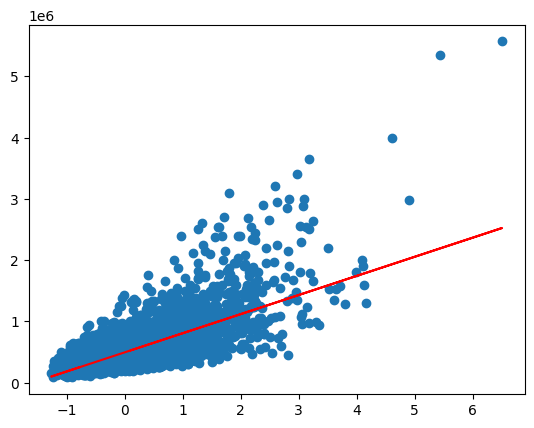

In [42]:
model_slr.fit(X_train, y_train)
predicted_data_point = model_slr.predict(X_test)

plt.scatter(X_test, y_test)
plt.plot(X_test, predicted_data_point, c='red')
plt.show()

## Multiple linear regression

### Feature selection
Select the feature variables (X) that will be used to predict the target variables (y)

In [43]:
feature = df_robust_scaled[['sqft_living', 'grade', 'sqft_above']]

> These features are selected based on correlation matrix

### Model development

In [44]:
# selecting target (y) variable
target = df_clean['price']

In [45]:
# randomly split the feature & target data into train set & test set
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=.2, random_state=42)

In [46]:
# construct the model
model_mlr = LinearRegression()

In [47]:
# train & validate the model using cross-validation method
scores = cross_validate(model_mlr, X_train, y_train,
                        scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'],
                        cv=10,
                        verbose=2)

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


In [48]:
scores

{'fit_time': array([0.02314734, 0.00769353, 0.00725555, 0.00893831, 0.00899601,
        0.00843358, 0.00774097, 0.00933027, 0.00708127, 0.00769591]),
 'score_time': array([0.00444603, 0.00410247, 0.00335956, 0.01167607, 0.00338292,
        0.00440073, 0.00369954, 0.00346971, 0.00345421, 0.00437307]),
 'test_r2': array([0.53057931, 0.53989042, 0.53015736, 0.54090821, 0.57568426,
        0.5210077 , 0.53540806, 0.55954715, 0.52000585, 0.55004363]),
 'test_neg_root_mean_squared_error': array([-272431.74099029, -233642.50421982, -267712.03081961,
        -232403.82073654, -230227.22156213, -261403.47593311,
        -249204.22486705, -240127.85775728, -233714.81787214,
        -250424.21215889]),
 'test_neg_mean_absolute_error': array([-166227.17209064, -159453.91034368, -162006.1462782 ,
        -160001.71023709, -155380.82952947, -163642.89787715,
        -165938.20795329, -157645.83113087, -163293.56438956,
        -160821.99830892])}

### Evaluation

The model will be evaluated by the metrics from cross-validation method. I will calculate the mean of every metrics. Cross-validation is important to make sure that the model behave similarly when validated on different test set.

In [49]:
# modelling metrics: coefficient of determination (r-squared)
round(np.mean(scores['test_r2']), 2)

0.54

In [50]:
# modelling metrics: root mean squared error (RSME)
round(np.mean(scores['test_neg_root_mean_squared_error']*-1))

247129

In [51]:
# modelling metrics: mean absolute error (MAE)
round(np.mean(scores['test_neg_mean_absolute_error']*-1))

161441

> Both RMSE and R- Squared quantifies how well a linear regression model fits a dataset. The **RMSE** tells how well the regression **model** **can predict** the value of the target variable in absolute terms. Meanwhile, **R- Squared** tells how well the **feature variables can explain** the variation in the target variable.
Further reading: https://medium.com/analytics-vidhya/mae-mse-rmse-coefficient-of-determination-adjusted-r-squared-which-metric-is-better-cd0326a5697e

> On top of that, there is also **MAE**. MAE is interpreted as the average error when making a prediction with the model. RMSE on the other hand can be interpreted as the average weighted performance of the model, where a larger weight is added to outlier predictions. Further reading: https://stephenallwright.com/rmse-vs-mae/

## Multiple linear regression with RFE
Previously, I build an MLR model that learnt from manually-selected features. Now, I will experiment on using the RFE algorithm to select best features.

### Model development

In [52]:
# randomly split the feature & target data into train set & test set
X = df_robust_scaled.drop('id', axis=1) # drop id since intuitively it won't affect house prices
y = df_clean['price']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [53]:
# train a linreg model by wrapping it on the RFE algorithm
# the RFE algorithm will using the cross-validation method
selector = RFECV(LinearRegression(), cv=10, scoring='r2')
selector.fit(X_train, y_train)

RFECV(cv=10, estimator=LinearRegression(), scoring='r2')

In [54]:
# show the ranking of features
list(zip(X_train.columns, selector.support_, selector.ranking_))

[('bedrooms', True, 1),
 ('bathrooms', True, 1),
 ('sqft_living', True, 1),
 ('sqft_lot', True, 1),
 ('floors', True, 1),
 ('waterfront', True, 1),
 ('view', True, 1),
 ('condition', True, 1),
 ('grade', True, 1),
 ('sqft_above', True, 1),
 ('sqft_basement', True, 1),
 ('yr_built', True, 1),
 ('yr_renovated', True, 1),
 ('zipcode', True, 1),
 ('lat', True, 1),
 ('long', True, 1),
 ('sqft_living15', True, 1),
 ('sqft_lot15', True, 1)]

> Surprisingly, all the features are considered equally important by the algorithm. Therefore, I would select all the features for this new model below.

In [55]:
# randomly split the feature & target data into train set & test set
feature = df_robust_scaled.drop('id', axis=1) # drop id since intuitively it won't affect house prices
target = df_clean['price']
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=.2, random_state=42)

In [56]:
# construct the model
model_mlr_2 = LinearRegression()

In [57]:
# train & validate the model using cross-validation method
scores = cross_validate(model_mlr_2, X_train, y_train,
                        scoring=['r2', 'neg_root_mean_squared_error', 'neg_mean_absolute_error'],
                        cv=10,
                        verbose=2)

[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.1s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s
[CV] END .................................................... total time=   0.0s


In [58]:
scores

{'fit_time': array([0.02476788, 0.0456326 , 0.03439498, 0.03416252, 0.03311348,
        0.03927946, 0.0263412 , 0.02909422, 0.03563356, 0.03641343]),
 'score_time': array([0.00790095, 0.00720286, 0.00865626, 0.00703406, 0.0075109 ,
        0.00373268, 0.0038569 , 0.00917363, 0.00720572, 0.00717854]),
 'test_r2': array([0.68467236, 0.70877294, 0.69881307, 0.6925855 , 0.73674984,
        0.67687418, 0.70325231, 0.71256317, 0.69732718, 0.69248756]),
 'test_neg_root_mean_squared_error': array([-223284.0050005 , -185881.88913803, -214343.21149292,
        -190175.98462883, -181341.17287609, -214700.43663075,
        -199165.09916595, -193983.16520371, -185590.17653534,
        -207024.84065029]),
 'test_neg_mean_absolute_error': array([-128199.07581746, -121018.69895214, -126502.66406591,
        -122996.63477654, -122193.48639597, -127375.60403748,
        -126570.90562975, -122645.55494658, -125515.00031559,
        -126262.85234158])}

## Evaluation

In [59]:
# modelling metrics: coefficient of determination (r-squared)
round(np.mean(scores['test_r2']), 2)

0.7

> The second MLR model with all features has a better performance compared to the previous models.

# Conclusion

1. I have successfully created 3 linear regression model to predict house prices.
2. The model with the best performance is created by utilizing all features in the dataset (multiple linreg model).
3. Next, I would try another algorithm that could also solved regression task. Check out my other notebook about predicting house price using tree regressor.